In [1]:
from time import time

import numpy as np
import pandas as pd

import torchvision

from tqdm import tqdm
from rsq import AgglomerativeEnsemble
from rsq.helpers import few_shot_sample, stratified_sample

from joblib import Parallel, delayed
import pickle

In [2]:
#- Data processing 1

class Dataset:
    def __init__(self, file='cifar_100_Bit_m-r101x1_embd.p', train=True, classes=[]):
        if train:
            self.data = pickle.load(open(file, 'rb'))[0][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[0][1])
        else:
            self.data = pickle.load(open(file, 'rb'))[1][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[1][1])
        
        self.classes = classes

In [3]:
#- Data processing 2
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)

trainset1 = Dataset('/home/hhelm/data/cifar_100_Bit_m-r101x1_embd.p')
trainset1.targets

X = trainset.data
y = trainset1.targets
X = np.mean(X, axis=-1)
X = X.reshape((X.shape[0], X.shape[1]**2))

X_test = testset.data
X_test = np.mean(X_test, axis=-1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]**2))
y_test = np.array(testset.targets).astype(int)

del trainset, trainset1, testset

Files already downloaded and verified
Files already downloaded and verified


In [12]:
def benchmark_agg_class(X, y, inds_sup, kwargs):
    y_ = -1 * np.ones(len(y))
    y_[inds_sup] = y[inds_sup]
    
    agg_class = AgglomerativeEnsemble(**kwargs)
    fit_time_ = time()

    agg_class.fit(X, y_)
    fit_time = time() - fit_time_
    
    inf_time_ = time()
    
    accuracy = (agg_class.predict(X_test) == y_test).mean()
    inf_time = time() - inf_time_
    
    print(accuracy, fit_time, inf_time)
    
    return accuracy, fit_time, inf_time

benchmark_agg_ = lambda x: benchmark_agg_class(*x)

In [18]:
np.random.seed(1)
import copy

n_cores=1
# n_mc=int(n_cores / len(prop_labeled))
n_mc=1
n_labeled_per_class=1

prop_data = [0.005, 0.01, 0.05, 0.1, 0.5]

kwargs = {'n_estimators':90, 'p_inbag':1, 
          'projector':'gaussian', 'projection_kwargs':{'n_components': 1024}, 
          'affinity':'gaussian', 'linkage':'average', 'n_neighbors':8,
          'max_tree_distance':400, 'n_jobs':90}

# experiment_tuples=[]
# for i, p in enumerate(prop_data):
#     for _ in range(n_mc):
        
#         all_inds = stratified_sample(y, p=p, replace=False)
#         inds_sup = few_shot_sample(y[all_inds])
#         experiment_tuples.append((X[all_inds], y[all_inds], inds_sup, kwargs))
            
start_time = time()
try:
    results = Parallel(n_jobs=n_cores)(delayed(benchmark_agg_)(tupl) for tupl in experiment_tuples)
    print("finished in %1.1f"%(time() - start_time))
except:
    print("error after %1.1f"%(time() - start_time))
    assert 0 == 1

0.0229 28.128438234329224 19.09263300895691
0.0296 1.391636848449707 22.900106191635132
error after 113.7


AssertionError: 

In [17]:
#-
from sklearn.svm import SVC
svc_accuracies=np.zeros(n_mc)

for i, tupl in enumerate(experiment_tuples):
    svc = SVC(kernel='linear')
    svc.fit(tupl[0][tupl[2]], tupl[1][tupl[2]])
    
    print((svc.predict(X_test) == y_test).mean())
#     svc_accuracies[i] = (svc.predict(X_test) == y_test).mean()

0.0257
0.028
0.0315
0.0259
0.0288


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import Isomap

iso_accuracies=np.zeros(n_mc)

for i, tupl in enumerate(experiment_tuples):
    iso = Isomap(n_neighbors=7, n_components=1024, n_jobs=50)
    iso.fit(tupl[0])
    
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(iso.predict(tupl[0][tupl[2]]), tupl[1][tupl[2]])
    
    iso_accuracies[i]  = (knn.predict(iso.tra(X_test)) == y_test).mean()

AttributeError: 'Isomap' object has no attribute 'predict'

In [23]:
print(svc_accuracies.mean())


0.29841


In [13]:
accuracies = np.zeros((len(n_estimators_list), n_mc))
fit_times = np.zeros((len(n_estimators_list), n_mc))
inf_times = np.zeros((len(n_estimators_list), n_mc))

for i, triple in enumerate(results_p_unlabeled):
    accuracies[int(np.math.floor(i/n_mc)), i%n_mc] = triple[0]
    fit_times[int(np.math.floor(i/n_mc)), i%n_mc] = triple[1]
    inf_times[int(np.math.floor(i/n_mc)), i%n_mc] = triple[2]

In [14]:
print(np.mean(accuracies, axis=-1))

[0.37064]


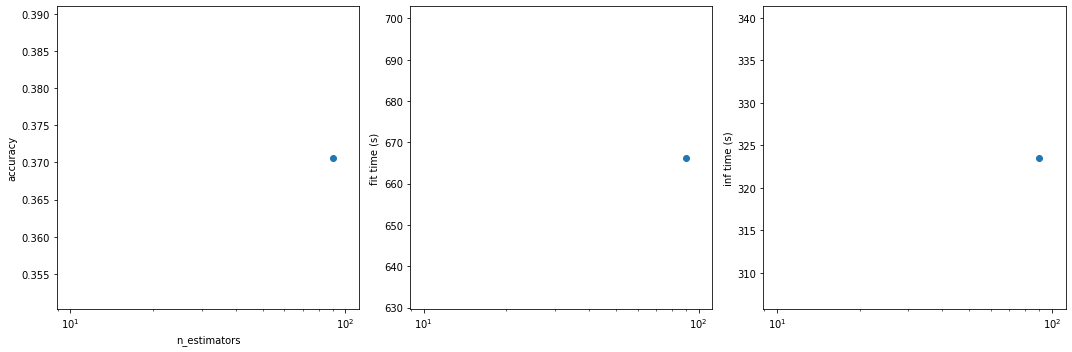

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5))

for ax_ in ax:
    ax_.set_xscale('log')

ax[0].scatter(n_estimators_list, np.mean(accuracies, axis=-1))
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n_estimators')

# fig, ax = plt.subplots(1,3)
ax[1].scatter(n_estimators_list, np.mean(fit_times, axis=-1))
ax[1].set_ylabel('fit time (s)')
# ax[1].set_xlabel('proportion o')

# fig, ax = plt.subplots(1,3)
ax[2].scatter(n_estimators_list, np.mean(inf_times, axis=-1))
ax[2].set_ylabel('inf time (s)')
# ax[2].set_xlabel('proportion of')

plt.tight_layout()

In [12]:
results_p_unlabeled

[(0.3955, 669.4218602180481, 325.5045096874237),
 (0.3573, 669.2849025726318, 321.4384970664978),
 (0.3564, 661.5938103199005, 323.49339962005615),
 (0.3632, 671.639096736908, 324.02057552337646),
 (0.3546, 654.8388876914978, 319.8550581932068),
 (0.36, 665.1161091327667, 321.142689704895),
 (0.3751, 655.8792457580566, 321.2531101703644),
 (0.3879, 669.2234268188477, 326.14515233039856),
 (0.3668, 674.5458481311798, 323.8187839984894),
 (0.3896, 671.2181124687195, 328.72952795028687)]